# Introduction

Importo il necessario


In [1]:
import os
import operator
import random
import re
import csv
import numpy as np
import pandas as pd
import seaborn as sn
import ghlinguist as ghl
import os.path
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.feature_extraction as fe
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
plt.style.use('seaborn')

# Document retrieval

Vado a recuperare i file che mi servono per la fase di training/testing. Il ciclo `for` serve per cerca nella repo clonata tutti i file la cui estensione appartiene alla lista `accepted`. Le estensioni presenti nell'array `accepted` sono le classi del classificatore. Quando un file che soddisfa il vincolo dell'estensione viene trovato, si controlla tramite il dict `file_num` che per quella estensione non sia già stato raggiunto il `max_num_of_files`. Infine, se tutti i controlli vengono superati, il file viene aggiunto all'array `file_list` e la sua estensione a `file_ext`. In `file_ext[i]` è presente l'estensione del file `file_list[i]`. La fine della cella serve per disegnare il Dataframe riepilogativo e un grafico a torta (attualmente inutile perchè viene usato un numero fisso di file `max_num_of_files`).



Num    1200
dtype: int64


<ipython-input-2-8648a2224006>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pie_chart.get_figure().show()


,Num
C,50
Common Lisp,50
Go,50
TypeScript,50
Ruby,50
Prolog,50
CMake,50
Shell,50
OCaml,50
Makefile,50


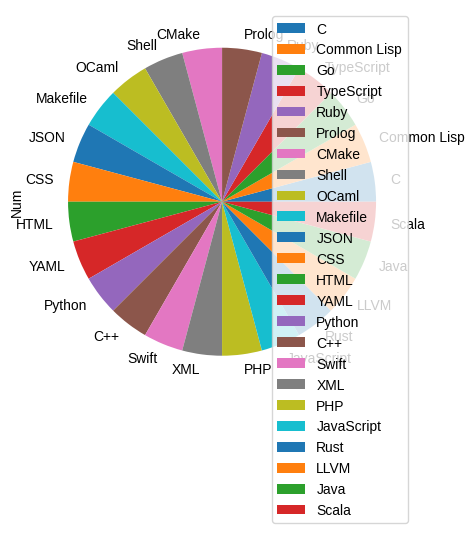

In [2]:
plt.style.use('default')

def check_open_utf8(f):
    try:
        open(f, 'r').read()
        return True
    except:
        return False

file_num = {}
file_list = []
file_ext = []
accepted = ["Java", "C++", "LLVM", "PHP", "C", "Rust", "Swift", "Common Lisp", "JavaScript","YAML", \
             "Python", "HTML", "XML", "JSON", "Makefile", "OCaml", "Shell", "CMake", "Ruby", "TypeScript", \
            "Scala", "Go", "CSS", "Prolog"]
max_num_of_files = 50

with open('source-code-set/listing.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if len(row) > 1:
            if row[0] and row[1]:
                if os.path.isfile(row[0]):
                    if row[1] in accepted:
                        add = False
                        if check_open_utf8(row[0]):
                            if row[1] in file_num:
                                if file_num[row[1]] < max_num_of_files:
                                    add = True
                                    file_num[row[1]] += 1
                            else:
                                add = True
                                file_num[row[1]] = 1
                            if add:
                                file_list.append(row[0])
                                file_ext.append(row[1])
    
# Mostro in output le informazioni sui file acquisiti
data = pd.DataFrame.from_dict(file_num, orient='index', columns=["Num"])
data = data.sort_values(by=["Num"], ascending=False)
# Disegno un grafico che le mostri
pie_chart = data.plot.pie(y='Num', figsize=(5, 5))
pie_chart.get_figure().show()
plt.style.use('seaborn')
print(data.sum(axis = 0, skipna = True))
data

# NLP

La funzione `preprocess` prende in input la lista contenente il nome dei file accettati nella sezione precedente, legge il contenuto dei documenti e restituisce una serie (di *Pandas*) con il contenuto dei file opportunamente modificato. Il primo e il secondo replace rimuovono tutte le stringhe del tipo `xxxx`, `aaaaa`, `b`, `c`. I successivi replace vanno a sostituire con delle keyword le porzioni di stringa contenenti commenti. Infatti, non mi interessa sapere il contenuto di un commento, è molto più interessante sapere il tipo di commento (e.g. `//.*?\n` diventa `ccommentstyle` nei linguaggi C-like o `#.*?\n` diventa `pycommentstyle` in quelli funzioniali/Python-like). Se si volessero inserire anche linguaggi come Prolog bisognerebbe aggiungere un replace per i commenti in stile `%.*?\n`.




La funzione `tokenizer`, invece, tramite `re.findall()` cerca, nella stringa in input, tutte le occorrenze che coincidono con la regex `token_pattern`. Infine, `tokenizer` cerca tra i token restituiti da `re.findall()`quelli che sono numerici e li rimpiazza con un token predefinito `XXXtokenNumberXXX`. L'output della funzione è una lista di tokens.

A questo punto vengono divisi training e test set, oltre a venir dichiarati `transformer` e `tfidf_vectorizer`. Il `TfidfVectorizer` ha come tokenizer la funzione `tokenizer` (di cui si è discusso prima), un numero di feature massimo di 3000 e gli ngram spaziano da 1 a 3. Tramite il Dataframe si possono visualizzare le 3000 feature, riportate tramite `PCA` anche nel grafico.

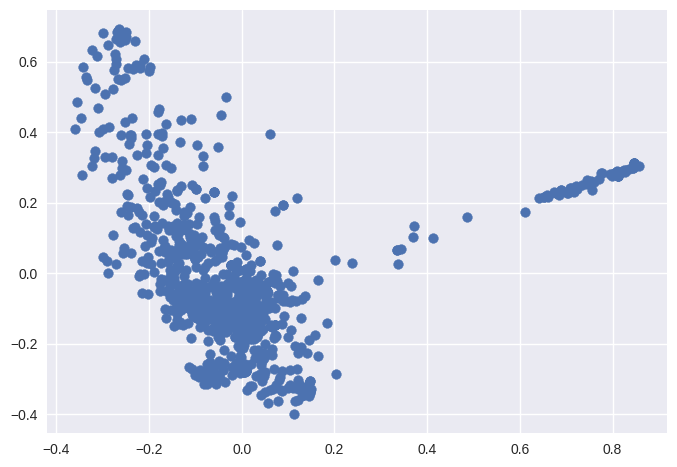

,\t,\t \t,\t $,\t (,\t -,\t .,\t <,\t @,\t @$,\t case,...,} return,} ruby_assert,} st,} subst,} switch,} val,} var,} {,} },~
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.001482,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.242692,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.011053,0.0
4,0.771423,0.410061,0.0,0.0,0.0,0.076647,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.002526,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
896,0.713451,0.506167,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
897,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
898,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.027674,0.0,0.000000,0.000000,0.0


In [3]:
def preprocess(x):
    ls_file = list(map(lambda v: open(v, 'r').read(), x))
    return pd.Series(ls_file).replace(r'\b([A-Za-z])\1+\b', '', regex=True) \
        .replace(r'\b[A-Za-z]\b', '', regex=True) \
        .replace(r'\/\*(\*(?!\/)|[^*])*\*\/', ' ccommentstyle ', regex=True) \
        .replace(r'//.*?\n', ' ccommentstyle ', regex=True) \
        .replace(r'#.*?\n', ' pycommentstyle ', regex=True) \
        .replace(r'%.*?\n', ' prologcommentstyle ', regex=True) \
        .replace(r'".*?"', ' doublequotedstring ', regex=True) \
        .replace(r"'.*?'", ' singlequotedstring ', regex=True) \
        .replace(r"'.'", ' singlecharacter ') \
        .replace(r'\(\*(\*(?!\))|[^*])*\*\)', ' mlcommentstyle ', regex=True)\
        .replace(r'<!--(.*?)-->', ' htmlcommentstyle ', regex=True)\
        .replace(r'<!--(.*?)-->', ' htmlcommentstyle ', regex=True)


def check_num(x):
    if x.isnumeric():
        return "XXXtokenNumberXXX"
    else:
        return x


def tokenizer(txt):
    token_pattern = r"""([0-9]+|[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[\t\(\),;\{\}\[\]"'`])"""
    tokens = re.findall(token_pattern, txt)
    tokens = list(map(check_num, tokens))
    return tokens

X_train, X_test, y_train, y_test = ms.train_test_split(file_list, file_ext, shuffle=True, test_size=0.25, random_state=0)
transformer = FunctionTransformer(preprocess)
tfidf_vectorizer = fe.text.TfidfVectorizer(ngram_range=range(1, 3), tokenizer=tokenizer, max_features=3000)
# Visualization
X = tfidf_vectorizer.fit_transform(transformer.fit_transform(X_train))


lb = LabelBinarizer()
lb.fit(accepted)
        
pca = PCA(n_components=2)
two_dim = pca.fit_transform(X.todense())

plt.scatter(two_dim[:, 0], two_dim[:, 1])
plt.show()
pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

# ML Parameters

Modelli, e relativi parametri, che vengono testati 

In [13]:
def baseline_model():
    # create model
    input_dim = X.toarray().shape[1]
    output_dim = len(y_train_enc[0])
    dim = int(2/3 * input_dim + output_dim)
    model = Sequential()
    model.add(Dense(dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

parameters = [ 
    {
        'clf':[ 
            Pipeline(
                [
                    ('transformer', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
                    ('clf', KerasClassifier(build_fn=baseline_model))
                ]
            )
        ],
        'name': 'ANN',
        'clf__clf__epochs': [10,50,100],
        'clf__clf__batch_size': [32,64,128,256],
        'clf__clf__verbose':[0]
    },
    {
        'clf': [RandomForestClassifier(n_jobs=-1)],
        'name': 'RandomForestClassifier',
        "clf__n_estimators": [300,500, 1000],
        "clf__criterion": ["gini", "entropy"],
        "clf__min_samples_split": [3],
        "clf__max_features": ["sqrt", "log2"]
    },
    {
        'clf': [SVC()],
        'name': 'SVC',
        'clf__C': [100,500, 1000, 10e5],
        'clf__kernel': ['linear', 'rbf'],
        'clf__class_weight': ['balanced'],
        'clf__probability': [True]
    }
]

TypeError: 'dict' object is not callable

# Fitting

Tramite `CV`, viene fatto il training dei vari modelli e viene stampato un valore di Accuracy. I risultati vengono memorizzati in **result** per una comparazione successiva.

In [12]:
result = []
for parameter in parameters:
    clf = parameter['clf'][0]
    name = parameter['name']
    parameter.pop('clf')
    parameter.pop('name')

    pipe_RF = Pipeline([
        ('preprocessing', transformer),
        ('vectorizer', tfidf_vectorizer),
        ('clf', clf)]
    )
    grid = GridSearchCV(pipe_RF, param_grid=parameter, cv=3)
    
    if name == "ANN":
        y_train_enc = lb.transform(y_train)
        grid.fit(X_train, y_train_enc)
        print(f' - {name} Accuracy: {grid.score(X_test, lb.transform(y_test))}')
    else:
        grid.fit(X_train, y_train)
        # Evaluation
        print(f' - {name} Accuracy: {grid.score(X_test, y_test)}')

    # storing result
    result.append({
        'grid': grid,
        'name': name,
        'classifier': grid.best_estimator_,
        'best score': grid.best_score_,
        'best params': grid.best_params_,
        'cv': grid.cv
    })

KeyError: 'clf'

# Output


Comparazione tra i migliori:

In [ ]:
result = sorted(result, key=operator.itemgetter('best score'), reverse=True)
pd.DataFrame.from_dict([{
      'name':v['name'],
      'score': v['best score'],
      'param': v['best params']
     } for v in result])

Quelli che risultano essere i migliori parametri per RandomForestClassifier:

In [ ]:
result[0]['best params']

Di seguito una matrice di confusione per visualizzare i risultati. Questa matrice fa riferimento al miglior modello (Random Forest con parametri precedenti). I valori sono normalizzati. Il linguaggio che ha il peggior risultato è TypeScript che viene spesso confuso con Java e JavaScript.

In [ ]:
SVC = None

for model in result:
    if model["name"] == "SVC":
        SVC = model

y_pred = SVC["grid"].best_estimator_.predict(X_test)

array = confusion_matrix(y_test, y_pred, normalize='true', labels=accepted)
df_cm = pd.DataFrame(array, index =accepted,
              columns =accepted)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.yticks(rotation=0)
plt

Questa matrice fa riferimento al miglior modello (Random Forest con parametri precedenti). I valori sono discreti. Il linguaggio che ha il peggior risultato è TypeScript che viene spesso confuso con Java e JavaScript.

In [ ]:
RandomForestP = None

for model in result:
    if model["name"] == "RandomForestClassifier":
        RandomForestP = model


y_pred = result[0]["grid"].best_estimator_.predict(X_test)

array = confusion_matrix(y_test, y_pred, normalize='true', labels=accepted)
df_cm = pd.DataFrame(array, index =accepted,
              columns =accepted)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.yticks(rotation=0)
plt

Questa matrice fa riferimento al secondo miglior modello (SVM con kernel=RBF e C=50). I valori sono normalizzati. Il linguaggio che ha il peggior risultato è TypeScript che viene spesso confuso con Java, JavaScript e C++.

In [ ]:
ANN = None

for model in result:
    if model["name"] == "ANN":
        ANN = model

y_pred = ANN["grid"].best_estimator_.predict(X_test)

def map_to_array(x):
    final = [0] * len(accepted)
    final[x] = 1
    return final
    
y_pred = np.array(list(map(map_to_array, list(y_pred))))
conf_matrix = confusion_matrix(y_test, lb.inverse_transform(y_pred), normalize='true', labels=accepted)
df_cm = pd.DataFrame(conf_matrix, index=accepted,
                     columns=accepted)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt

Per Random Forest mostro le 20 stringhe con *feature importances* più alto:

In [ ]:
plt.style.use('seaborn')

randomfor = None

for model in result:
    if model["name"] == "RandomForestClassifier":
        randomfor = model
        
importances = randomfor["grid"].best_estimator_["clf"].feature_importances_

plt.figure(figsize = (10,7))

(pd.Series(importances, index=tfidf_vectorizer.get_feature_names())
   .nlargest(20)
   .plot(kind='barh'))  